In [1]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# Ejercicio


En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas en el internet de hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el tipo de contenido de odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. Será necesario incorporar características adicionales como el sentimiento o características léxicas.

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


**Nota 1**: El ejercicio propuesto es similar a los ejercicios de clasificación visto en clase, por lo que es importante que documentéis y expliquéis adecuadamente (con vuestras palabras) los procesos llevados a cabo en el ejercicio. No hacerlo puede llegar a penalizar hasta 1 punto en la calificación final.

**Nota 2**: Cualquier cálculo adicional a los vistos en clase (visualizaciones, nuevas características añadidas al modelo...) será valorado positivamente en la calificación.

## 0. Imports


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
from tqdm.autonotebook import tqdm
tqdm.pandas()

import string
import re
!{sys.executable} -m pip install contractions
import contractions

!pip install spacy==3.2.1
!pip install emoji_extractor
from emoji_extractor.extract import Extractor
!python -m spacy download en_core_web_sm
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('opinion_lexicon')
nltk.download('subjectivity')
nltk.download('vader_lexicon')
nltk.download('wordnet')

!pip install vaderSentiment
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

<ipython-input-2-da40a1f5d264>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.5/659.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.2
    Uninstalling wasabi-1.1.2:
      Successfully uninstalled wasabi-1.1.2
  Attempting uninstall: typer
    Found existing installation: typer 0.9.4
    Uninstalling typer-0.9.4:
      Successfully uninstalled typer-0.9.4
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.7.1
    Uninstalling pydantic-2.7.1:
      Successfully uninstalled pydantic-2.7.1
  Attempting uninstall: thinc
    Found existing ins

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.
[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Unzipping corpora/subjectivity.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.1 MB/s eta 0:00:00


## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [3]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
# Path de datos alternativos en caso de que el anterior no funcione (al estar alojado en github puede haber limitaciones
# en la descarga.
# path_data = "https://zenodo.org/records/10938455/files/cyberbullying_tweets.csv?download=1"
dataset = load_prepare_data(path_data)

In [4]:
dataset.head(4)

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0


## 2. Análisis exploratorio

En este apartado realizaremos un análisis de los datos previos a la normalización de los mismos. Este análisis nos va a permitir extraer información relevante del dataset, así como posibles inconvenientes.

En primer lugar, mostraremos el número de documentos y columnas.

- **Número de documentos y columnas:**

In [5]:
print("Tenemos un conjunto de {} documentos".format(len(dataset)))
print("El dataframe tiene {} columnas".format(dataset.shape[1]))

Tenemos un conjunto de 47692 documentos
El dataframe tiene 2 columnas


- **Número de documentos** **Duplicados:**

In [6]:
num_total_documentos = len(dataset)
num_documentos_duplicados = np.sum(dataset.duplicated(subset=["tweet_text"]))

porcentaje_documentos_duplicados = (num_documentos_duplicados / num_total_documentos) * 100

print("Existen {} documentos duplicados, lo que representa el {:.2f}% del total de documentos.".format(num_documentos_duplicados, porcentaje_documentos_duplicados))

Existen 1675 documentos duplicados, lo que representa el 3.51% del total de documentos.


Eliminamos los tweets duplicados

In [7]:
dataset = dataset.drop_duplicates(subset=["tweet_text"])
print("Despues de quitar duplicados tenemos un conjunto de {} documentos".format(dataset.shape[0]))

Despues de quitar duplicados tenemos un conjunto de 46017 documentos


Observamos si no han quedado Nulls en ninguna de las columnas del dataset

In [8]:
print("Hay {} valores vacíos en las noticias y {} valores vacíos en las etiquetas en los datos".format(np.sum(dataset.isnull())[0],
                                                                                                        np.sum(dataset.isnull())[1]))

Hay 0 valores vacíos en las noticias y 0 valores vacíos en las etiquetas en los datos


**- Numero de documentos para cada clase:**

In [9]:
dataset.groupby(['cyberbullying']).count()

,tweet_text
cyberbullying,
0,7937
1,38080


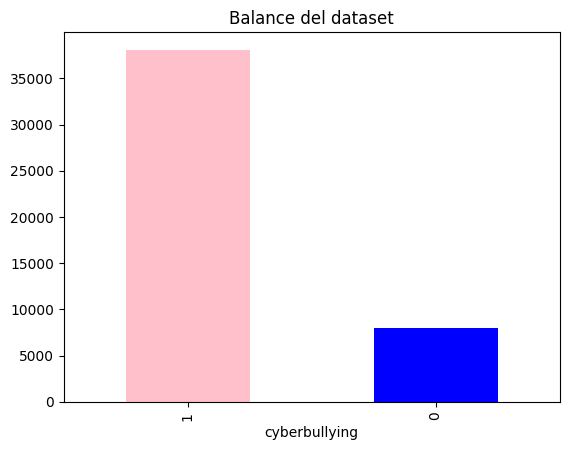

In [10]:
ax, fig = plt.subplots()
etiquetas = dataset.cyberbullying.value_counts()
etiquetas.plot(kind= 'bar', color= ["pink", "blue"])
plt.title('Balance del dataset')
plt.show()

Observamos los resultados podemos observar que el conjunto de datos no tiene las categorías balanceadas. Por tanto, antes del entrenamiento habrá que balancear los datos para que no haya problema en el entrenamiento de los modelos.

- **Distribución de la longitud de los tweet en caracteres:**

Realizamos el cálculo la longitud de cada uno de los textos de los documentos para ver las diferencias del dataset

In [11]:
dataset["char_len"] = dataset["tweet_text"].apply(lambda x: len(x))

In [12]:
dataset.head(2)

,tweet_text,cyberbullying,char_len
0,"In other words #katandandre, your food was cra...",0,61
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115


<Figure size 1400x1200 with 0 Axes>

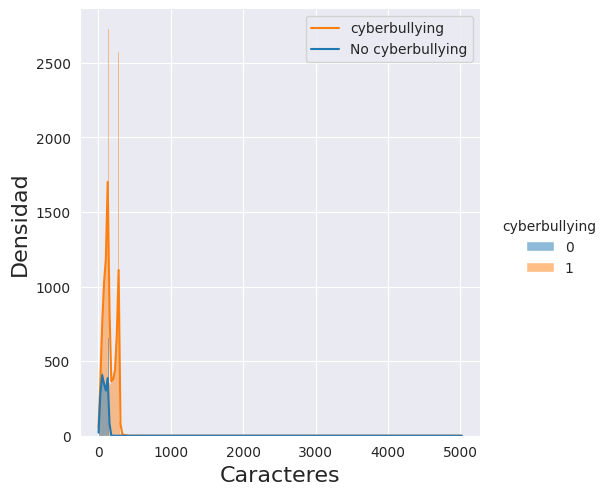

In [13]:

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=dataset, x="char_len", hue="cyberbullying", kde=True, legend=True)
plt.legend(["cyberbullying", "No cyberbullying"])
# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()


Observamos que la densidad de la distribución puede tener muchos outliers vamos a observar, el boxplot.

<Axes: xlabel='char_len'>

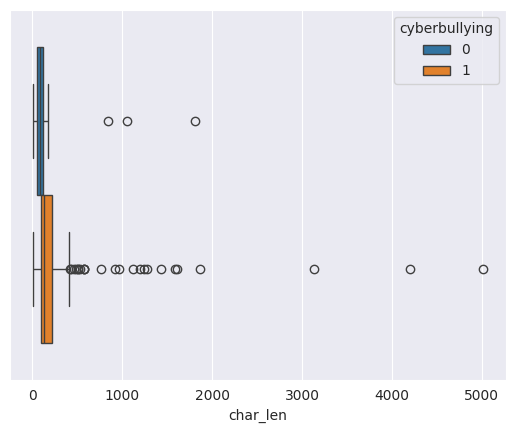

In [14]:
sns.boxplot(data=dataset, x="char_len", hue="cyberbullying")

Calculamos el rango intercualítico y el límite superior

In [15]:
Q1 = np.percentile(dataset['char_len'], 25, method='midpoint')
Q3 = np.percentile(dataset['char_len'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper = Q3+1.5*IQR
print("Límite superior:", upper)




107.0
Límite superior: 347.5


Observamos que existe una considerable cantidad de outliers. Siendo el límite superior 347.5, nos encontramos con valores hasta de 5000 caracteres.


Eliminamos los outliers que sean mayores del límite superior del rango intercuartílico. Y observamos la distribución.  

<Axes: xlabel='char_len'>

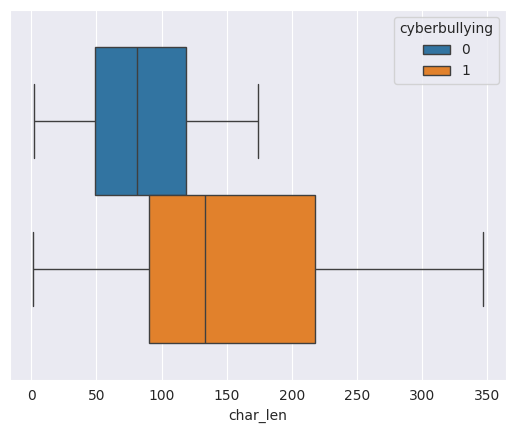

In [16]:
dataset = dataset[dataset["char_len"] < upper]
sns.boxplot(data=dataset, x="char_len", hue="cyberbullying")

<Figure size 1400x1200 with 0 Axes>

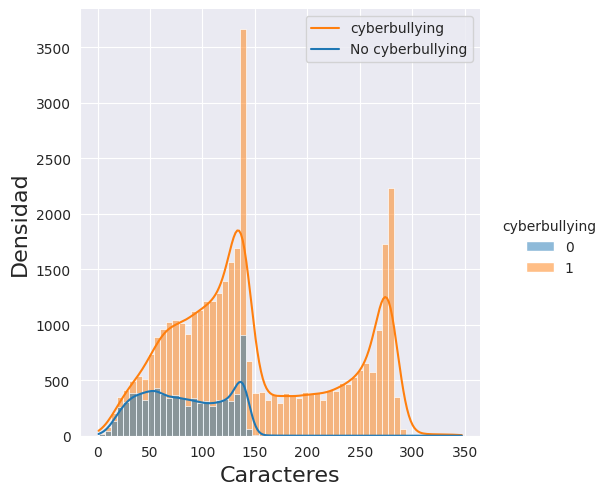

In [17]:
fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=dataset, x="char_len", hue="cyberbullying", kde=True, legend=True)
plt.legend(["cyberbullying", "No cyberbullying"])
# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

Podemos interpretar que  los tweets que expresan cyberbullying tienen una longitud mayor a los tweets que no expresan cyberbullying.


---



- **Análisis de contenido de los tweets**
Para ello, realizaremos el wordcloud, en la que se representa visualmente los términos más frecuentes de un conjunto.


Importamos el objeto WordCloud

In [18]:
from wordcloud import WordCloud

Separamos los twets asociados con cada categoría para generar los gráficos

In [19]:
txt_cat0 = ",".join(dataset[dataset.cyberbullying==0].tweet_text.to_list())
txt_cat1 = ",".join(dataset[dataset.cyberbullying==1].tweet_text.to_list())

Al obtener las variables de textos, crearemos un objeto Wordcloud con la configuración que nos permita crear las visualizaciones

In [20]:
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0,
                      contour_color='steelblue', stopwords=en_stopwords,
                      normalize_plurals = True,collocation_threshold=100)

Wordcloud no cyberbullying

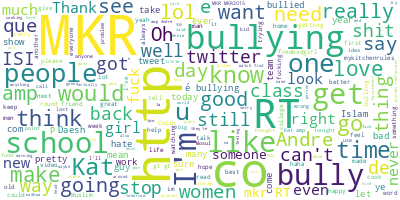

In [21]:
# Genera el wordcloud
wordcloud.generate(txt_cat0)
# Visualizalo en una imagen
wordcloud.to_image()

Wordcloud cyberbullying

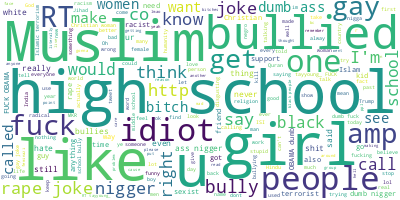

In [22]:
# Genera el wordcloud
wordcloud.generate(txt_cat1)
# Visualizalo en una imagen
wordcloud.to_image()

Observamos los siguientes resultados:


*   En el wordcloud de la categoría 0 se observa una alta presencia de URLs (presencia de https y co). Así como, go, going y got, añadiendo ruido al dataset.
También encontramos MKR donde no sabríamso definir su significado.
*   En el wordcloud de la categoría 1 se observa entre las palabras frecuentes http pero en menor frecuencia que la categoría 0.  Aparecen adjetivos que expresan opinión y cyberbullying como hate, dumb o bitch.

Se observan similitudes de términos entre ambos grupos como fuck, shit y bully. Aunque existen varias diferencias en el resto del contenido.



### - **Análisis del sentimiento.**

Los datos de redes sociales como Twitter contienen emojis que pueden ayudar a entender el sentimiento de la frase. Por tanto, los analizaremos.

Para empezar con el análisis realizaremos una función para extraer emojis del texto en formato lista.



In [23]:
# Función para extraer emojis del texto en formato lista
def extract_emojis(text):
  extract = Extractor()
  emojis = extract.count_emoji(text, check_first=False)
  emojis_list = [key for key, _ in emojis.most_common()]
  return emojis_list

Extraemos los emoticonos a una columna específica en el dataframe

In [24]:
dataset["emojis"] = dataset["tweet_text"].apply(lambda x: extract_emojis(x))

Observaremos el número de documentos que tienen emojis.

In [25]:
filas_con_icono = dataset[dataset['emojis'].apply(lambda x: len(x) >= 1)]
filas_sin_icono = dataset[dataset['emojis'].apply(lambda x: len(x) ==0)]

# Imprimir el resultado
print("Número de filas con al menos un icono:", len(filas_con_icono))
print("Número de filas sin iconos:", len(filas_sin_icono))

Número de filas con al menos un icono: 408
Número de filas sin iconos: 45553


Se observa que en torno al 0.009% de documentos tiene emojis. No llega al 1% del dataset por tanto, podemos descartar su análisis ya que representan una fracción muy muy pequeña del conjunto de datos.

Podemos realizar el análisis con la librería NTLK para extraer sentimiento utilizando diferentes diccionarios de sentimiento. Utilizaremos funciones para calcular sentimiento utilizando el lexicon de VADER.

In [26]:
from nltk.sentiment.vader import SentiText,SentimentIntensityAnalyzer #https://github.com/cjhutto/vaderSentiment
sentsss=SentimentIntensityAnalyzer()
sentsss

In [29]:
print(sentsss.polarity_scores(txt_cat0))

{'neg': 0.168, 'neu': 0.708, 'pos': 0.124, 'compound': -1.0}


In [84]:
print(sentsss.polarity_scores(txt_cat1))

{'neg': 0.339, 'neu': 0.513, 'pos': 0.149, 'compound': -1.0}


Observamos que cuando los tweets tienen una connotación de bullying, la negatividad aumenta a 0.339. La neutralidad y la positividad se reducen.

## 3. Preprocesado y Normalización

En primer lugar, procedemos a normalizar los datos, para ello generamos pequeñas funciones que nos permitan:


1.   Eliminar los espacios extra entre términos
2.   Transformar a minúsculas
3.   Reemplazar contracciones del inglés
4.   Normalizar URLs, menciones de twitter y números por tokens comunes.
5.   Lematizar tokens, eliminar stopwords y eliminar signos de puntuación.


En primer lugar, eliminaremos espacios extra del texto y transformaremos todos los caracteres a minúsculas.




In [31]:
# Eliminar espacios
def eliminar_espacios(text):
    return  " ".join(text.split())

# To lower
def texto_to_lower(text):
  return text.lower()

In [32]:
# Espacios
dataset["normalized"] = dataset["tweet_text"].progress_apply(lambda x: eliminar_espacios(x))
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: texto_to_lower(x))

  0%|          | 0/45961 [00:00<?, ?it/s]

  0%|          | 0/45961 [00:00<?, ?it/s]

A continuación, normalizaremos las contracciones y slang existentes en inglés.

In [33]:
import contractions

In [34]:
def replace_contraction(text):
    return contractions.fix(text, slang=True)

In [35]:
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: replace_contraction(x))

  0%|          | 0/45961 [00:00<?, ?it/s]

Normalizamos los URLs, menciones de twitter y números. Optamos por tokenizar el documento y en función de las características sustituiremos el token o lo dejaremos igual.


In [36]:
# Tokenizador
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

def normalizar_tokens(documento):
    # Dividir el documento en palabras
    palabras =  tweet_tokenizer.tokenize(documento)

    # Reemplazar URLs, menciones de Twitter y números por los tokens correspondientes
    for i in range(len(palabras)):
        if palabras[i].startswith("http://") or palabras[i].startswith("https://") or palabras[i].startswith("www."):
            palabras[i] = "URL"
        elif palabras[i].startswith("@"):
            palabras[i] = "MENTION"
        elif palabras[i].isdigit():
            palabras[i] = "NUM"

    # Unir las palabras de nuevo en un documento modificado
    documento_modificado = ' '.join(palabras)

    return documento_modificado

In [37]:
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: normalizar_tokens(x))

  0%|          | 0/45961 [00:00<?, ?it/s]

Finalmente, realizamos la lematización y eliminación de puntuación y stopwords.

In [38]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lematizar_eliminacion_tokens(texto):
    # Procesar el texto con el objeto nlp
    doc = nlp(texto)

    # Lematizar el texto
    lemas = [token.lemma_ for token in doc]

    # Eliminar símbolos de puntuación y stopwords
    tokens_filtrados = [token for token in lemas if token.isalpha() and token.lower() not in en_stopwords]

    # Unir los tokens filtrados en un nuevo texto
    texto_procesado = ' '.join(tokens_filtrados)

    return texto_procesado

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [39]:
dataset["preprocessed_text"] = dataset["normalized"].progress_apply(lambda x: lematizar_eliminacion_tokens(x))

  0%|          | 0/45961 [00:00<?, ?it/s]

In [40]:
dataset.preprocessed_text

0                   word katandandre food crapilicious mkr
1        aussietv white mkr theblock imacelebrityau tod...
2                  MENTION classy whore red velvet cupcake
3        MENTION meh thank head concerned another angry...
4        MENTION isis account pretend kurdish account l...
                               ...                        
47687    black people expect anything depend anything y...
47688    turner withhold disappointment turner call cou...
47689    swear god dumb nigger bitch get bleach hair re...
47690    yea fuck rt MENTION nigger fucking unfollow fu...
47691    bro got chill rt MENTION dog fuck kp dumb nigg...
Name: preprocessed_text, Length: 45961, dtype: object

Tras realizar el preprocesado, observamos que aunque en algunos textos aparece la palabra mkr y tipo de slang. Se ha realizado correctamente la normalización.

Rehacemos los word clouds para interpretar mejor el contenido de éste y visualizar el correcto funcionamiento del proceso.

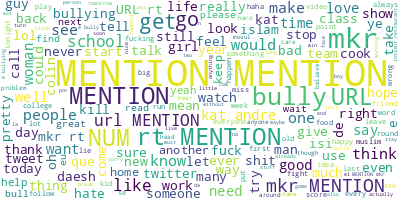

In [41]:
txt_cat0 = ",".join(dataset[dataset.cyberbullying==0].preprocessed_text.to_list())
txt_cat1 = ",".join(dataset[dataset.cyberbullying==1].preprocessed_text.to_list())
#
# Genera el wordcloud
wordcloud.generate(txt_cat0)
# Visualizalo en una imagen
wordcloud.to_image()

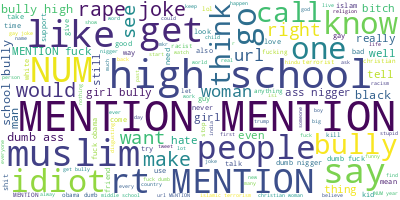

In [42]:
# Genera el wordcloud
wordcloud.generate(txt_cat1)
# Visualizalo en una imagen
wordcloud.to_image()

Una vez preprocesado, calculamos alguna característica adicional, como el número de URLs o menciones

In [43]:
def token_appearance(document, token = "MENTION"):
  return len([x for x in document.split() if x == token])

In [44]:
dataset["num_mention"] = dataset["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="MENTION"))
dataset["num_URLS"] = dataset["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="URL"))
dataset["num_NUM"] = dataset["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="NUM"))

  0%|          | 0/45961 [00:00<?, ?it/s]

  0%|          | 0/45961 [00:00<?, ?it/s]

  0%|          | 0/45961 [00:00<?, ?it/s]

### Características del sentimiento


Vamos a calcular el sentimiento asociado a los textos de los documentos utilizando TextBlob:

In [45]:
from textblob import TextBlob
dataset["tweet_sentiment_polarity"] = dataset["preprocessed_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
dataset["tweet_sentiment_subjectivity"] = dataset["preprocessed_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

<Axes: >

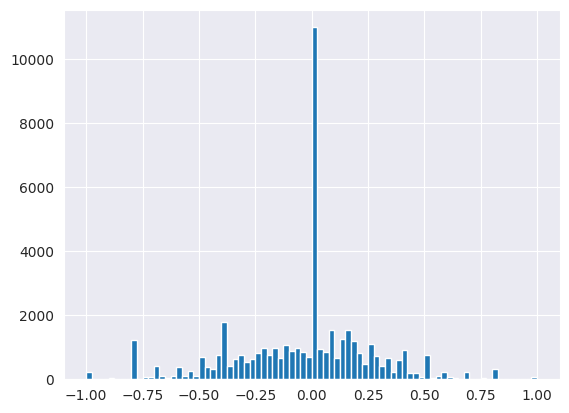

In [46]:
dataset["tweet_sentiment_polarity"].hist(bins=80)

<Axes: >

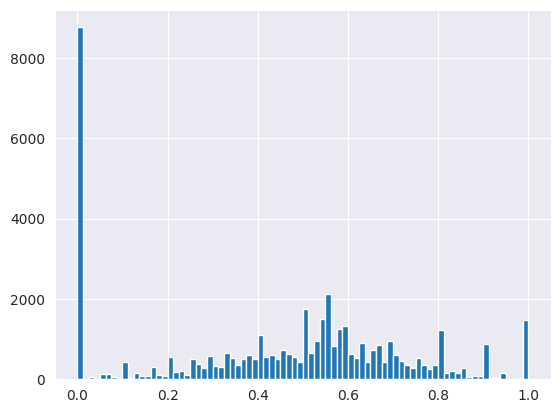

In [47]:
dataset["tweet_sentiment_subjectivity"].hist(bins=80)

## 4. Vectorización

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizador = TfidfVectorizer(lowercase = False, stop_words =None,
                               min_df=0.005, ngram_range = (1,3))

vector_data_tfidf = vectorizador.fit_transform(dataset["preprocessed_text"])

In [49]:
vector_data_tfidf

<45961x408 sparse matrix of type '<class 'numpy.float64'>'
	with 381176 stored elements in Compressed Sparse Row format>

Para realizar la  vectorización, utilizaremos el word-embedding estática ya que captura las relaciones semánticas.
En este caso, utilizaremos un embedding pre-entrenado de la librería Gensim.

Este tipo de embedding solo permite obtener representaciones vectoriales de palabras individuales. Por tanto, construimos un vector calculado como la media de los vectores.

In [50]:
import gensim.downloader as api

In [51]:
glove_emb = api.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [52]:
def tokenize(texto):
  tweet_tokenizer = TweetTokenizer()
  tokens_list = tweet_tokenizer.tokenize(texto)
  return tokens_list

In [53]:
def get_average_vector(sentence):
  #retokenizamos con nuestra función
  tokens = tokenize(sentence)
  lista = list()
  for i in tokens:
    try:
      lista.append(glove_emb.get_vector(i) )
    except:
      continue

  try:
    resultado = np.mean(lista, axis=0)
  except:
    resultado = np.zeros(25)
  return resultado

In [54]:
dataset["embeddings"] =dataset["preprocessed_text"].progress_apply(lambda x: get_average_vector(x))

  0%|          | 0/45961 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [55]:
dataset.head(2)

,tweet_text,cyberbullying,char_len,emojis,normalized,preprocessed_text,num_mention,num_URLS,num_NUM,tweet_sentiment_polarity,tweet_sentiment_subjectivity,embeddings
0,"In other words #katandandre, your food was cra...",0,61,[],"in other words #katandandre , your food was cr...",word katandandre food crapilicious mkr,0,0,0,0.0,0.0,"[-0.04117, 0.02057, 0.41728333, 0.20775497, -0..."
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115,[],why is #aussietv so white ? #mkr #theblock #im...,aussietv white mkr theblock imacelebrityau tod...,0,0,0,0.0,0.0,"[-0.058562864, -0.060735855, 0.13847415, -0.06..."


Conectamos embeddings y características extras:

In [56]:
vector_data_embeddings_feats1 = pd.concat([dataset.embeddings.apply(pd.Series),
               dataset[["tweet_sentiment_polarity","tweet_sentiment_subjectivity","num_mention","num_URLS","num_NUM"]]], axis=1)

In [57]:
vector_data_embeddings_feats1.shape

(45961, 105)

In [58]:
vector_data_embeddings_feats1 = vector_data_embeddings_feats1.fillna(0)

In [59]:
import scipy as sp
# Extraemos las etiquetas y las asignamos a la variable y
y = dataset["cyberbullying"].values.astype(np.float32)
X = sp.sparse.hstack((vector_data_tfidf,vector_data_embeddings_feats1.values),format='csr')

In [60]:
X


<45961x513 sparse matrix of type '<class 'numpy.float64'>'
	with 5032082 stored elements in Compressed Sparse Row format>

# Entrenamiento/testeo modelo


### División train/text

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape)
print(X_test.shape)

(34470, 513)
(11491, 513)


### Rebalanceo de clases

El desbalanceo provoca problemas de rendimientos.

In [62]:
# Cargamos
from imblearn.over_sampling import SMOTE
# Creamos objetos
sm = SMOTE(random_state=42)
# Retransformamos
X_res, y_res = sm.fit_resample(X_train, y_train)

Observamos el resultado del rebalanceo

In [63]:
np.array(np.unique(y_res, return_counts=True)).T

array([[0.0000e+00, 2.8525e+04],
       [1.0000e+00, 2.8525e+04]])

### Decisión de modelo ML a utilizar

In [64]:
# Definimos las funcionalidades pertinentes de sklearn:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore')
          # Generamos un Kfold
          KF = KFold(n_splits = 10, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)

          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

Una vez definida la función, podemos definir los modelos con el que hacer la evaluación

In [65]:
# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("Logistic",LogisticRegression(random_state=30)),
         ("GaussianNB",GaussianNB()),
         ("DecisionTree", DecisionTreeClassifier(random_state=30)),
         ("RandomForest", RandomForestClassifier(random_state=30))
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X_res.toarray(), y_res)

Metric: accuracy , KFold 
Logistic: 0.860333 (0.002341) 
Metric: accuracy , KFold 
GaussianNB: 0.787046 (0.005939) 
Metric: accuracy , KFold 
DecisionTree: 0.872568 (0.003901) 
Metric: accuracy , KFold 
RandomForest: 0.919509 (0.002486) 


([array([0.86029798, 0.86432954, 0.85854514, 0.85766871, 0.86134969,
         0.85924628, 0.86047327, 0.85644172, 0.86345311, 0.86152498]),
  array([0.78737949, 0.79263804, 0.79263804, 0.78860649, 0.78001753,
         0.7780894 , 0.79018405, 0.78299737, 0.79684487, 0.78106924]),
  array([0.87028922, 0.8774759 , 0.8716915 , 0.87291849, 0.87028922,
         0.87835232, 0.87256792, 0.8659071 , 0.8774759 , 0.86871166]),
  array([0.92007011, 0.92427695, 0.91954426, 0.91463628, 0.92164768,
         0.92007011, 0.91814198, 0.9167397 , 0.9202454 , 0.91971954])],
 ['Logistic', 'GaussianNB', 'DecisionTree', 'RandomForest'])

Observamos que el mayor valor de accurracy se obtiene con RandomForest a 0.919, será con el que intentemos afinar los hiperparámetros:

In [66]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = RandomForestClassifier()
criterion=["entropy"]
n_estimators=[300]
random_state=[30]


Generamos un diccionario para la búsqueda Grid y también generamos el objeto GridSearchCV.

In [67]:
grid = dict(criterion=criterion,n_estimators=n_estimators, random_state=random_state)
cv = KFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

Entrenamos el grid_search para obtener el mejor parámetro para nuestro conjunto de datos

In [96]:
grid_result = grid_search.fit(X_res, y_res)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.885101 usando los parámetros {'criterion': 'entropy', 'n_estimators': 300, 'random_state': 30}


 Como podemos observar, en el grid el score se reduce, ya que sin grid se obtenía 0.919 y ahora se obtiene 0.8851.

## Modelo con balanceado de datos

In [76]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=RandomForestClassifier(random_state=30)
model.fit(X_res,y_res)

RandomForestClassifier(random_state=30)

In [77]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1500  489]
 [1231 8271]]
              precision    recall  f1-score   support

         0.0       0.55      0.75      0.64      1989
         1.0       0.94      0.87      0.91      9502

    accuracy                           0.85     11491
   macro avg       0.75      0.81      0.77     11491
weighted avg       0.88      0.85      0.86     11491



**Modelo no balanceado**

              precision    recall  f1-score   support

         0.0       0.73      0.42      0.53      1989
         1.0       0.89      0.97      0.93      9502
         accuracy                     0.87     11491
         macro avg 0.81      0.69      0.73     11491
         weighted avg0.86    0.87      0.86     11491

Con el modelo balanceado, el acurracy es el 85%. Pero obtenemos un mayor rendimiento en recall en comparación al no balanceado ya que es un modelo donde ambas clases son igualmente importantes.

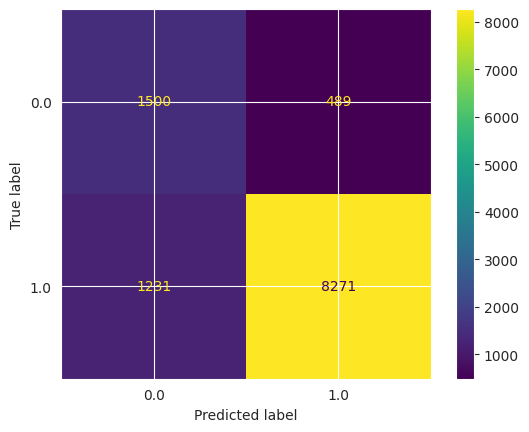

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize = None)

### Modelo sin balanceado de datos

In [69]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=RandomForestClassifier(random_state=30)
model.fit(X_train,y_train)

RandomForestClassifier(random_state=30)

Predecimos con el set de test y creamos una matriz de confusión y un "classification report"

In [70]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 828 1161]
 [ 311 9191]]
              precision    recall  f1-score   support

         0.0       0.73      0.42      0.53      1989
         1.0       0.89      0.97      0.93      9502

    accuracy                           0.87     11491
   macro avg       0.81      0.69      0.73     11491
weighted avg       0.86      0.87      0.86     11491



Como podemos observar en el classification report, el modelo parece funcionar mejor para la categoría 1 (cyberbullying) en comparación al 0 (no cyberbullying). Observamos que el accurracy del modelo es 0.87, es decir, predice correctamente el 87%.

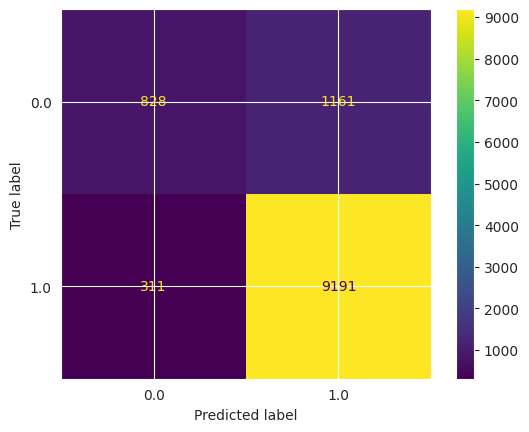

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize = None)